# Lab 1: Fairness and Machine Learning
Welcome to the first DS102 lab! 

The goals of this lab are to get familiar with concepts in decision theory (true positive rates, false positive rates, etc.) through the lens of fairness in machine learning. This lab is adapted from Chapter 2 of the book [Fairness and Machine Learning: Limitations and Opportunities](https://fairmlbook.org).

The code you need to write is commented out with a message "TODO: fill in". There is additional documentation for each part as you go along.


## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thursday, January 30, 2020 at 11:59 PM.**

# Collaborators
Write the names of your collaborators in this cell.

# Introduction

Risk assessment is an important component of the criminal justice system. In the United States, judges set
bail and decide pre-trial detention based on their assessment of the risk that a released defendant would fail to
appear at trial or cause harm to the public. While actuarial risk assessment is not new in this domain, there
is increasing support for the use of learned risk scores to guide human judges in their decisions. Proponents
argue that machine learning could lead to greater efficiency and less biased decisions compared with human
judgment. Critical voices raise the concern that such scores can perpetuate inequalities found in historical
data, and systematically harm historically disadvantaged groups.

In this lab, we’ll begin to scratch at the surface of the complex criminal justice domain. Our
starting point is an investigation carried out by ProPublica of a proprietary risk score, called the COMPAS
score. These scores are intended to assess the risk that a defendant will re-offend, a task often called
recidivism prediction. Within the academic community, the ProPublica article drew attention to issues with the use of machine learning for decision making.

# Setup
Let's begin by importing the libraries we will use. 
* [matplotlib](https://matplotlib.org/3.1.1/contents.html)
* [numpy](https://docs.scipy.org/doc/)
* [pandas](https://pandas.pydata.org/pandas-docs/stable/)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd

%matplotlib inline

# Imports and helper functions used for tests. 
import hashlib
import sys
def get_hash(num):
    return hashlib.md5(str(num).encode()).hexdigest()

# Dataset setup
We’ll use data obtained and released by ProPublica as a result of a public records request in Broward
Country, Florida, concerning the COMPAS recidivism prediction system. The data is available at https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv. Following ProPublica’s analysis, we’ll filter out rows where `days_b_screening_arrest` is over $30$ or under $−30$, leaving us with $6,172$ rows.

Here, we will download the data from the link above and apply this filter.

In [2]:
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(data_url)
df = df.query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')
len(df)

6172

In [3]:
# We will also filter the data for only two races.
races = ['African-American', 'Caucasian']
df = df[df['race'].isin(races)]

# 1. From scores to classifiers
We will observe what happens when we use COMPAS risk scores to create a classifier to predict whether an individual will re-offend (recidivate).
We are not given the original COMPAS risk score, but we are given a column which contains the decile of the COMPAS risk score (similar to a percentile, but out of 10). We will refer to this decile value (a number between 1 and 10) as our COMPAS "decile score". Our classifier will take the form of a threshold on the COMPAS decile score.


### Group the dataset by `race` and `decile_score`.

In [6]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
11,15,ellyaher lanza,ellyaher,lanza,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,...,4,Low,2013-10-03,2013-10-03,2013-10-07,3,4,128,1,1
12,16,kortney coleman,kortney,coleman,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,...,1,Low,2013-01-01,2013-01-01,2013-01-02,0,1,1186,0,0
13,18,jarrod turbe,jarrod,turbe,2013-10-09,Male,1974-12-02,41,25 - 45,African-American,...,2,Low,2013-10-09,2013-10-08,2013-10-09,0,0,905,0,0
14,19,craig gilbert,craig,gilbert,2013-10-30,Female,1968-06-14,47,Greater than 45,Caucasian,...,1,Low,2013-10-30,2014-06-03,2014-11-19,1,0,216,1,1
15,20,samuel seraphin,samuel,seraphin,2014-06-03,Male,1985-03-25,31,25 - 45,African-American,...,2,Low,2014-06-03,2014-06-25,2014-06-28,7,0,22,1,1


In [4]:
# Create a separate dataframe for each race and decile_score pair.
groups = df.groupby(['race', 'decile_score'], as_index=False)


## 1a) For each `race`/`decile_score` pair, compute:
1. the number of cases where recidivism occurred within two years,
2. the number of cases where recidivism did not occur, and 
3. the total number of examples in the dataframe. 

Note: the column `two_year_recid` is a column that takes value 1 if recidivism occurred within two years, and 0 if recidivism did not occur.

In [7]:
# TODO: compute the total number of examples in which recidivism occured within two years.
def recid_count_fn(df_recid_column):
    """Computes the total number of examples in which recidivism occurred.
    
    Args: 
      df_recid_column: dataframe column where each row takes value 1 if 
        recidivism occured, and 0 if recidivism did not occur.
    
    Returns: 
      The total number of rows in which recidivism occurred.
    """
    recid_count = np.sum(df_recid_column) # TODO
    return recid_count 

print("Total number of examples of recidivism in the dataset:", recid_count_fn(df['two_year_recid']))

# Test for correctness of this function.
assert(get_hash(recid_count_fn(df['two_year_recid'])) == '2c6ae45a3e88aee548c0714fad7f8269')
print("Test passed!")


('Total number of examples of recidivism in the dataset:', 2483)
Test passed!


In [8]:
# TODO: compute the total number of examples in which recidivism did not occur within two years.
def non_recid_count_fn(df_recid_column):
    """Computes the total number of examples in which recidivism did not occur.
    
    Args: 
      df_recid_column: dataframe column where each row takes value 1 if 
        recidivism occured, and 0 if recidivism did not occur.
    
    Returns: 
      The total number of rows in which recidivism did not occur.
    """
    non_recid_count = np.size(df_recid_column) - np.sum(df_recid_column) # TODO
    return non_recid_count 


print("Total number of examples of non-recidivism in the dataset:", non_recid_count_fn(df['two_year_recid']))

# Test for correctness of this function.
assert(get_hash(non_recid_count_fn(df['two_year_recid'])) == 'a7f592cef8b130a6967a90617db5681b')
print("Test passed!")


('Total number of examples of non-recidivism in the dataset:', 2795)
Test passed!


In [9]:
# TODO: Compute the total number of examples in the dataset.
def total_count_fn(df_recid_column):
    """Computes the total number of examples in the dataset.
    
    Args: 
      df_recid_column: dataframe column where each row takes value 1 if 
        recidivism occured, and 0 if recidivism did not occur.
    
    Returns: 
      The total number of rows in the dataset.
    """
    total_count = np.size(df_recid_column) # TODO
    return total_count 

print("Total number of examples in the dataset:", total_count_fn(df['two_year_recid']))

# Test for correctness of this function.
assert(get_hash(total_count_fn(df['two_year_recid'])) == '82f292a22966b857d968fb578ccbead9')
print("Test passed!")

('Total number of examples in the dataset:', 5278)
Test passed!


### Create the `summary` dataframe
We now create a dataframe called `summary`, where each row contains summary statistics for each `race`/`decile_score` pair, including the total number of examples with that race and decile_score (`total_count`), the number of examples with that race and decile_score where recidivism occurred (`recid_count`), and the number of examples with that race and decile_score where recidivism did not occur (`non_recid_count`).

The `.agg` function below applies the functions you just wrote over a column of the dataframe corresponding to each `race`/`decile_score` pair. 
Each function will be computed on the column `two_year_recid` for each `race`/`decile_score` pair.

In [10]:
# Each function will be computed on the column 'two_year_recid' for each group.
# Note: no TODOs in this cell, just run the cell and understand what it's doing.
summary = groups['two_year_recid'].agg({'recid_count': recid_count_fn, 'non_recid_count': non_recid_count_fn, 'total_count': total_count_fn})


In [33]:
summary

,race,decile_score,total_count,recid_count,non_recid_count,TP,TN,FP,FN,TPR,FPR,PPV
0,African-American,1,365,85,280,1661.0,0.0,1514.0,0.0,1.000000,1.000000,0.523150
1,African-American,2,346,105,241,1576.0,280.0,1234.0,85.0,0.948826,0.815059,0.560854
2,African-American,3,298,125,173,1471.0,521.0,993.0,190.0,0.885611,0.655878,0.596997
3,African-American,4,337,158,179,1346.0,694.0,820.0,315.0,0.810355,0.541612,0.621422
4,African-American,5,323,158,165,1188.0,873.0,641.0,473.0,0.715232,0.423382,0.649535
5,African-American,6,318,187,131,1030.0,1038.0,476.0,631.0,0.620108,0.314399,0.683931
6,African-American,7,343,209,134,843.0,1169.0,345.0,818.0,0.507526,0.227873,0.709596
7,African-American,8,301,215,86,634.0,1303.0,211.0,1027.0,0.381698,0.139366,0.750296
8,African-American,9,317,229,88,419.0,1389.0,125.0,1242.0,0.252258,0.082563,0.770221
9,African-American,10,227,190,37,190.0,1477.0,37.0,1471.0,0.114389,0.024439,0.837004


## 1b) Compute the classifier outcomes for different decision thresholds.

For each race in the `summary` dataframe, we will now observe the outcomes of the classifier when the decision threshold occurs at each `decile_score`.

Specifically, we will iterate through the `decile_scores` in the `summary` dataframe, and for each `decile_score`, we will compute the number of true positives, true negatives, false positives, and false negatives under the assumption that the decision threshold occurs just below this `decile_score`. For example, in the row of the `summary` dataframe corresponding to a `decile_score` of 5, we will compute the number of true positives under the assumption that every example receiving a `decile_score` of 5 or above is classified as positive.


In [18]:
# TODO: compute the number of true positives assuming the decision threshold 
# occurs just below each decile_score.
# If you'd like, you may also restructure the loop inside this function 
# (but do not change the function definition).
def get_TP_column(summary_df):
    """Returns an array of the number of true positives for each decile_score threshold.
    
    Args:
      summary_df: dataframe containing columns for 'decile_score', 'recid_count', 
        'non_recid_count', and 'total_count' for a single race.
    
    Returns:
      An array of the number of true positives for each decile_score (under the assumption that every example
      receiving that row's decile_score or above is classified as positive -- aka, the decision threshold occurs
      just below the row's decile score.)
    """
    TPs = []
    for threshold in summary_df['decile_score']:
        # TODO: compute the number of true positives for the current decile_score.
        true_positives = summary_df[summary_df['decile_score'] >= threshold]['recid_count'].sum()
        # END TODO 
        TPs.append(true_positives)
    return np.array(TPs, dtype=np.int32)

print("TP column for Caucasian:", get_TP_column(summary[summary['race']=='Caucasian']))

assert(get_hash(get_TP_column(summary[summary['race']=='Caucasian'])) == 'fdca79d31fe11760d9c6a06a4f8cb660')
print("Test passed!")


('TP column for Caucasian:', array([822, 694, 594, 512, 414, 323, 230, 162,  90,  35], dtype=int32))
Test passed!


In [13]:
# TODO: compute the number of true negatives assuming the decision threshold 
# occurs just below each decile_score.
def get_TN_column(summary_df):
    """Returns an array of the number of true negatives for each decile_score threshold.
    
    Args:
      summary_df: dataframe containing columns for 'decile_score', 'recid_count', 
        'non_recid_count', and 'total_count' for a given race.
    
    Returns:
      An array of the number of true negatives for each decile_score (under the assumption that every example
      receiving that row's decile_score or above is classified as positive -- aka, the decision threshold occurs
      just below the row's decile score.)
    """
    TNs = []
    for decile_score in summary_df['decile_score']:
        # TODO: compute the number of true negatives for this decile_score.
        true_negatives = summary_df[summary_df['decile_score'] < decile_score]['non_recid_count'].sum()
        # END TODO
        TNs.append(true_negatives)
    return np.array(TNs, dtype=np.int32)

print("TN column for Caucasian:", get_TN_column(summary[summary['race']=='Caucasian']))

assert(get_hash(get_TN_column(summary[summary['race']=='Caucasian']))  == '8175ee4854079441b234ca97e7f9a1c5')
print("Test passed!")

('TN column for Caucasian:', array([   0,  477,  698,  854,  999, 1108, 1175, 1220, 1244, 1266],
      dtype=int32))
Test passed!


In [15]:
# TODO: compute the number of false positives assuming the decision threshold 
# occurs just below each decile_score.
def get_FP_column(summary_df):
    """Returns an array of the number of false positives for each decile_score threshold.
    
    Args:
      summary_df: dataframe containing columns for 'decile_score', 'recid_count', 
        'non_recid_count', and 'total_count' for a given race.
    
    Returns:
      An array of the number of false positives for each decile_score (under the assumption that every example
      receiving that row's decile_score or above is classified as positive -- aka, the decision threshold occurs
      just below the row's decile score.)
    """
    FPs = []
    for decile_score in summary_df['decile_score']:
        # TODO: compute the number of false positives for this decile_score.
        false_positives = summary_df[summary_df['decile_score'] >= decile_score]['non_recid_count'].sum()
        # END TODO
            
        FPs.append(false_positives)
    return np.array(FPs, dtype=np.int32)

print("FP column for Caucasian:", get_FP_column(summary[summary['race']=='Caucasian']))

assert(get_hash(get_FP_column(summary[summary['race']=='Caucasian']))  == 'bc995fd0c02ad77eb6924ea48482f9ed')
print("Test passed!")


('FP column for Caucasian:', array([1281,  804,  583,  427,  282,  173,  106,   61,   37,   15],
      dtype=int32))
Test passed!


In [16]:
# TODO: compute the number of false negatives assuming the decision threshold 
# occurs just below each decile_score.
def get_FN_column(summary_df):
    """Returns an array of the number of false negatives for each decile_score threshold.
    
    Args:
      summary_df: dataframe containing columns for 'decile_score', 'recid_count', 
        'non_recid_count', and 'total_count' for a given race.
    
    Returns:
      An array of the number of false negatives for each decile_score (under the assumption that every example
      receiving that row's decile_score or above is classified as positive -- aka, the decision threshold occurs
      just below the row's decile score.)
    """
    FNs = []
    for decile_score in summary_df['decile_score']:
        # TODO: compute the number of false negatives for this decile_score.
        false_negatives = summary_df[summary_df['decile_score'] < decile_score]['recid_count'].sum()
        # END TODO
        FNs.append(false_negatives)
    return np.array(FNs, dtype=np.int32)

print("FN column for Caucasian:", get_FN_column(summary[summary['race']=='Caucasian']))

assert(get_hash(get_FN_column(summary[summary['race']=='Caucasian']))  == 'f680125060a0bfb18a1447c6658fdfb8')
print("Test passed!")


('FN column for Caucasian:', array([  0, 128, 228, 310, 408, 499, 592, 660, 732, 787], dtype=int32))
Test passed!


In [19]:
# Note: no TODOs in this cell, just run it to assign the columns you created to the summary dataframe.
# Fill in the TP, TN, FP, FN for each race.
for race in races:
    rows = summary['race'] == race
    summary.loc[rows, 'TP'] = get_TP_column(summary[rows])
    summary.loc[rows, 'TN'] = get_TN_column(summary[rows])
    summary.loc[rows, 'FP'] = get_FP_column(summary[rows])
    summary.loc[rows, 'FN'] = get_FN_column(summary[rows])
summary.fillna(0 , inplace=True)

In [14]:
# Note to instructors: here's a faster way to compute these metrics using cumsum.
# Fill in the TP, TN, FP, FN for each race.
for race in races:
    rows = summary['race']== race
    summary.loc[rows[::-1], 'TP'] = summary[rows][::-1]['recid_count'].cumsum()
    summary.loc[rows,'TN'] = summary[rows]['non_recid_count'].cumsum().shift(1)
    summary.loc[rows[::-1], 'FP'] = summary[rows][::-1]['non_recid_count'].cumsum()
    summary.loc[rows, 'FN'] = summary[rows]['recid_count'].cumsum().shift(1)
summary.fillna(0 , inplace=True)

In [31]:
summary

,race,decile_score,total_count,recid_count,non_recid_count,TP,TN,FP,FN,TPR,FPR,PPV
0,African-American,1,365,85,280,1661.0,0.0,1514.0,0.0,1.000000,1.000000,0.523150
1,African-American,2,346,105,241,1576.0,280.0,1234.0,85.0,0.948826,0.815059,0.560854
2,African-American,3,298,125,173,1471.0,521.0,993.0,190.0,0.885611,0.655878,0.596997
3,African-American,4,337,158,179,1346.0,694.0,820.0,315.0,0.810355,0.541612,0.621422
4,African-American,5,323,158,165,1188.0,873.0,641.0,473.0,0.715232,0.423382,0.649535
5,African-American,6,318,187,131,1030.0,1038.0,476.0,631.0,0.620108,0.314399,0.683931
6,African-American,7,343,209,134,843.0,1169.0,345.0,818.0,0.507526,0.227873,0.709596
7,African-American,8,301,215,86,634.0,1303.0,211.0,1027.0,0.381698,0.139366,0.750296
8,African-American,9,317,229,88,419.0,1389.0,125.0,1242.0,0.252258,0.082563,0.770221
9,African-American,10,227,190,37,190.0,1477.0,37.0,1471.0,0.114389,0.024439,0.837004


## 1c) Plot the ROC curve for each race. 
Here, we will compute the the true positive rate (TPR), false positive rate (FPR), and positive predictive value (PPV) metrics. PPV is also known as precision, and is defined as the number of true positives divided by the number of examples classified as positive. 

Then, we will plot the ROC curve for each race. 


In [24]:
# TODO: compute the TPR for each race using other columns in summary.
summary['TPR'] = summary['TP'] / (summary['FN'] + summary['TP']) # TODO

assert(get_hash(np.array(summary['TPR'].round(1), dtype=np.float32)) == '4e6755717caed5f4d6a62fc6fe8abbee')
print("Test passed!")

Test passed!


In [25]:
# TODO: compute the FPR for each race using other columns in summary.
summary['FPR'] = summary['FP'] / (summary['FP'] + summary['TN']) # TODO

assert(get_hash(np.array(summary['FPR'].round(1), dtype=np.float32)) == 'e0eba6216d5fada1d6eabbfe568c527b')
print("Test passed!")

Test passed!


In [28]:
# TODO: compute the PPV for each race using other columns in summary.
summary['PPV'] = summary['TP'] / (summary['TP'] + summary['FP']) # TODO

assert(get_hash(np.array(summary['PPV'].round(1), dtype=np.float32))  == '6db5b24b7cd46af910f6a781eee40134')
print("Test passed!")

Test passed!


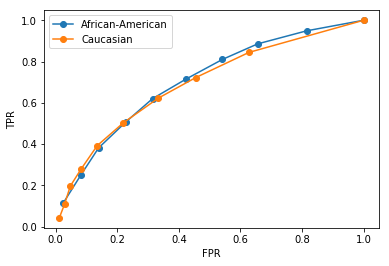

In [29]:
# TODO: plot the ROC curve for each race.
plt.figure()

for race in races: 
    rows = summary[summary['race']==race]
    plt.plot(rows['FPR'], rows['TPR'], '-o', label=race) # TODO
    
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


## 1d) Equalizing TPR and FPR.
Can you find two thresholds (one for black defendants, one for white defendants) such that FPR and TPR are roughly equal for the two groups (say, within 1% of each other)? 
Note: trivial thresholds of 0 or 11
don’t count. Hint: it may be helpful to look at the ROC curves for each race.

In [39]:
# TODO: choose a threshold for each race corresponding to a 
# decile_score between 1 and 10 such that the FPR and TPR are 
# roughly equal for the two groups.

caucasian_threshold = 5 # TODO
african_american_threshold = 7 # TODO

thresh = {'Caucasian': caucasian_threshold, 'African-American': african_american_threshold}  

In [40]:
# Measure the TPR and FPRs for the thresholds you chose.
# Note: no TODOs in this cell, just run it and observe the result.
for race in races:
    fpr = float(summary[(summary['race'] == race) & (summary['decile_score'] == thresh[race])]['FPR'])
    tpr = float(summary[(summary['race'] == race) & (summary['decile_score'] == thresh[race])]['TPR'])
    print("for {}, fpr={} and tpr={}".format(race, fpr, tpr))

for African-American, fpr=0.22787318362 and tpr=0.507525586996
for Caucasian, fpr=0.220140515222 and tpr=0.503649635036


In [38]:
# Compute the PPV for the thresholds that you chose. Does equalizing TPR and FPR also equalize PPV?
# Note: no TODOs in this cell, just run it and observe the result.
for race in races:
    ppv = float(summary[(summary['race'] == race) & (summary['decile_score'] == thresh[race])]['PPV'])
    print("for {}, ppv={}".format(race, ppv))

for African-American, ppv=0.523149606299
for Caucasian, ppv=0.390870185449


 ## 1e) Conclusions and implications
In this lab, we studied the consequences of creating a binary classifier by applying a decision threshold to a numerical score (COMPAS's `decile_score`). For different decision thresholds, we measured the TPR, FPR, and the PPV. Now, we will take a closer look at what those measurements mean in the context of fairness.

Chapter 2 of [Fairness and Machine Learning: Limitations and Opportunities](https://fairmlbook.org) introduces the concepts of **Sufficiency** and **Separation** as possible non-discrimination criteria. 

1. Separation says that the classifier decisions are independent of the sensitive attribute (race) conditioned on the label (whether or not recidivism occurred). In other words, for all of the examples where recidivism actually occurred, the probability that the classifier outputs a positive decision should not differ between the races. Which of the metrics we measured today (TPR, FPR, and PPV) best signals whether the classifier achieves separation? Does the classifier we chose in 1d) achieve separation? 

TODO: fill in your answer.

**Answer:** the TPR measures the probability that the classifier outputs a positive decision conditioned on the label being positive. Therefore, if the TPRs are equal across races, then that means that conditioned on the label being positive, the classifier outputs roughly the same number of positive classifications for both races. Since the classifier we chose at the end has roughly equal TPR and FPR for both races, it appears to satisfy separation.

2. Sufficiency says that the label (whether or not recidivism occurred) is independent of the sensitive attribute (race) conditioned on the classifier decisions. In other words, for all of the examples where the classifier outputs a positive decision, the probability of recidivism actually having occurred for those examples should not differ between the races. Which of the metrics we measured today (TPR, FPR, and PPV) best signals whether the classifier achieves sufficiency? Does the classifier we chose in 1d) achieve sufficiency?

TODO: fill in your answer.

**Answer:** the PPV measures the probability that the label is positive conditioned on the classifier outputing a positive decision. Therefore, if the PPVs are equal across races, then that means that conditioned on the classifier outputing a positive decision, the rate of recidivism is roughly the same for both races. However, since the classifier we chose at the end does NOT have the same PPV, it does not achieve sufficiency.
